In [44]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [45]:
model = pybamm.lithium_ion.SPM()
experiment = pybamm.Experiment(["Discharge at 1C for 1 hour"])
sim = pybamm.Simulation(model, experiment=experiment)
solution = sim.solve()

In [46]:
c_neg_var = solution["X-averaged negative particle concentration [mol.m-3]"]
c_neg_data = c_neg_var.entries
time_data = solution["Time [s]"].entries

In [47]:
# We want 5 evenly spaced points between start (0) and the actual end of simulation
actual_end_time = time_data[-1]
target_times = np.linspace(0, actual_end_time, 5)

In [48]:
n_r = c_neg_data.shape[0]
r_vals = np.linspace(0, 1, n_r) # normalized r

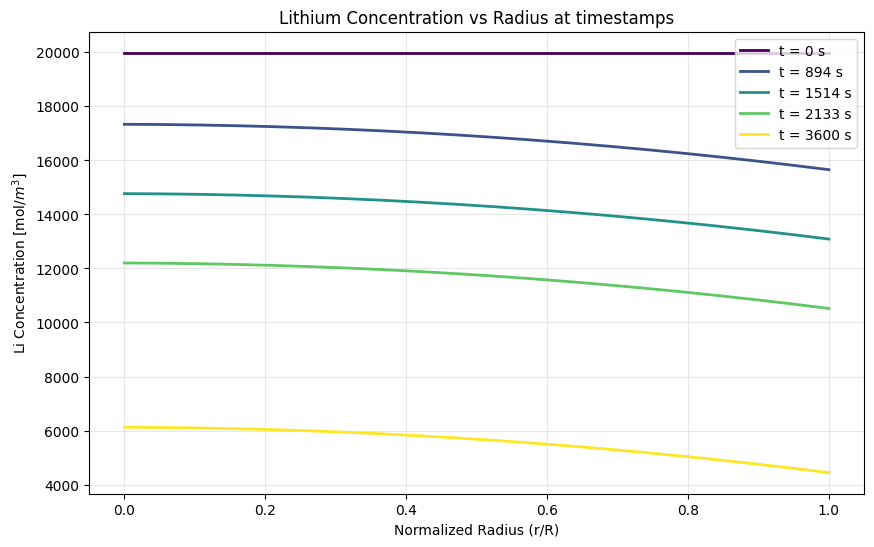

In [49]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(target_times)))

for i, t_target in enumerate(target_times):
    idx = np.argmin(np.abs(time_data - t_target)) #we find the index for the time closest to our target time

    t_actual = time_data[idx]

    profile = c_neg_data[:, idx] # concentration profile at that time

    plt.plot(r_vals, profile, color=colors[i], lw=2, label=f"t = {t_actual:.0f} s")

plt.xlabel("Normalized Radius (r/R)")
plt.ylabel("Li Concentration [mol/$m^3$]")
plt.title("Lithium Concentration vs Radius at timestamps")
plt.legend()
plt.grid(True, alpha=0.3)


plt.show()

In [50]:
# Now we make the animated plots
voltage_data = solution["Terminal voltage [V]"].entries

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

c_min = np.min(c_neg_data)
c_max = np.max(c_neg_data)
margin = (c_max - c_min) * 0.05

ax1.set_xlim(0, 1)
ax1.set_ylim(c_min - margin, c_max + margin)
ax1.set_xlabel("Normalized Radius (r/R)")
ax1.set_ylabel("X-averaged negative particle oncentration [mol/$m^3$]")
ax1.set_title("Radial Distribution over time")
ax1.grid(True, alpha=0.3)

line_conc, = ax1.plot([], [], lw=2, color='tab:blue', label="Concentration Gradient")
ax1.legend(loc="upper right")



ax2.set_xlim(0, time_data[-1])
ax2.set_ylim(2.5, 4.3) # Standard Li-ion range
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Voltage (V)")
ax2.set_title("Terminal Voltage")
ax2.grid(True, alpha=0.3)

ax2.plot(time_data, voltage_data, color='gray', alpha=0.3, lw=1)

point_voltage, = ax2.plot([], [], 'ro', markersize=8, label="Current State")
ax2.legend(loc="upper right")

title = fig.suptitle(f"Time: 0 s", fontsize=14)

def update(frame_idx):
    current_time = time_data[frame_idx]

    current_profile = c_neg_data[:, frame_idx]
    line_conc.set_data(r_vals, current_profile)

    current_voltage = voltage_data[frame_idx]
    point_voltage.set_data([current_time], [current_voltage])

    title.set_text(f"Discharge at 1C | Time: {current_time:.1f} s")

    return line_conc, point_voltage, title

step = 10
frames = range(0, len(time_data), step)

ani = FuncAnimation(
    fig,
    update,
    frames=frames,
    interval=800, # Time between frames in ms
    blit=True
)

plt.close()
HTML(ani.to_jshtml())